In [125]:
import os
import numpy as np
import pandas as pd
# from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

In [2]:
data_storage_directory = r"C:\temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

# Find repetitive cells

In [21]:
cells_table = cache.get_ophys_cells_table()
cells_table

,cell_specimen_id,ophys_experiment_id
cell_roi_id,,
1080884343,1086496928,775614751
1080884173,1086496914,775614751
1080883843,1086496838,775614751
1080886674,1086491756,775614751
1080885658,1086491699,775614751
...,...,...
1115385589,1120127229,1110928073
1115385513,1120127083,1110928073
1115301580,1120126794,1110928075


In [8]:
uniqueCellIDs, uniqueCellCount = np.unique(cells_table['cell_specimen_id'], return_counts=True)

(array([2.3287e+04, 6.8020e+03, 5.1330e+03, 4.5390e+03, 4.4020e+03,
        4.3810e+03, 1.2170e+03, 6.0600e+02, 1.0600e+02, 1.6000e+01]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

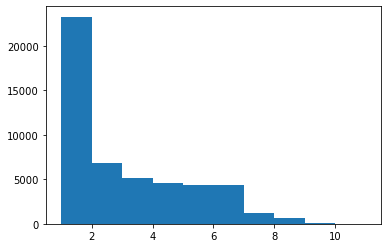

In [94]:
plt.hist(uniqueCellCount)

In [20]:
# select cells repeat more than 5 times
repeatCount = 5
cells_table_selected = cells_table.loc[cells_table['cell_specimen_id'].isin(uniqueCellIDs[uniqueCellCount > repeatCount])]
cells_table_selected

,cell_specimen_id,ophys_experiment_id
cell_roi_id,,
1080905923,1086540341,792813858
1080905907,1086539950,792813858
1080905893,1086539623,792813858
1080905876,1086539275,792813858
1080905830,1086537218,792813858
...,...,...
1115365254,1120128890,1108445073
1115365250,1120128823,1108445073
1115365243,1120128748,1108445073


In [63]:
experiment_table = cache.get_ophys_experiment_table()
cells_meta_table_selected = cells_table_selected.copy()
metadata_keys = [
        'ophys_session_id',
        'imaging_depth',
        'targeted_structure',
        'session_type',
        'experience_level',
        'passive',
        'image_set',
        'full_genotype',
        'mouse_id',
        'sex',
    ]

for experimentID in tqdm(cells_table_selected['ophys_experiment_id'].unique()):
    # Somehow some experiments in cell table are not in ophys table. 
    if len(experiment_table.query('ophys_experiment_id == @experimentID')) != 1:
        continue
    for metadata_key in metadata_keys:
        cells_meta_table_selected.loc[cells_meta_table_selected.ophys_experiment_id == experimentID, metadata_key] = \
            experiment_table.query('ophys_experiment_id == @experimentID')[metadata_key].values[0]
        
        
        

  0%|          | 0/1477 [00:00<?, ?it/s]

In [65]:
cells_meta_table_selected

,cell_specimen_id,ophys_experiment_id,ophys_session_id,imaging_depth,targeted_structure,session_type,experience_level,passive,image_set,full_genotype,mouse_id,sex
cell_roi_id,,,,,,,,,,,,
1080905923,1086540341,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
1080905907,1086539950,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
1080905893,1086539623,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
1080905876,1086539275,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
1080905830,1086537218,792813858,7.923273e+08,375.0,VISp,OPHYS_1_images_A,Familiar,False,A,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366.0,F
...,...,...,...,...,...,...,...,...,...,...,...,...
1115365254,1120128890,1108445073,1.108352e+09,175.0,VISl,OPHYS_6_images_H,Novel >1,False,H,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,563231.0,F
1115365250,1120128823,1108445073,1.108352e+09,175.0,VISl,OPHYS_6_images_H,Novel >1,False,H,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,563231.0,F
1115365243,1120128748,1108445073,1.108352e+09,175.0,VISl,OPHYS_6_images_H,Novel >1,False,H,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,563231.0,F


In [193]:
def selectRepeatedCells(df, countTot = 10):

    selectedCells = pd.DataFrame({})
    count = 0
    for i in range(len(df)):
        if count >= countTot:
            break
        cell = df.iloc[i]
        restCells = df.iloc[np.arange(i+1, len(df))]
        nextAppearance = restCells.loc[restCells.cell_specimen_id == cell.cell_specimen_id]
        if len(nextAppearance) > 0:
            nextAppearance = nextAppearance.iloc[0]
        else:
            continue
        if ('OPHYS_1' in cell.session_type) and ('OPHYS_4' in nextAppearance.session_type):
            selectedCells = pd.concat([selectedCells, cell, nextAppearance], axis = 1)
            count += 1
    return selectedCells.T

In [204]:
cellType = 'Vip'

selectedCells = cells_meta_table_selected.copy()
selectedCells = selectedCells.loc[selectedCells['full_genotype'].str.contains(cellType, na = False)]
selectedCells = selectedCells.query('passive == False')
selectedCells = selectedCells.loc[selectedCells['session_type'].str.contains('OPHYS_1_images_A', na = False) | \
                                  selectedCells['session_type'].str.contains('OPHYS_4_images_B', na = False)]
selectedCells = selectedCells.query('targeted_structure == "VISp"')

uniqueCellIDs, uniqueCellCount = np.unique(selectedCells['cell_specimen_id'], return_counts=True)
selectedCells = selectedCells.loc[selectedCells['cell_specimen_id'].isin(uniqueCellIDs[uniqueCellCount > 1])]

selectedCells = selectRepeatedCells(selectedCells, countTot = 20)

selectedCells.to_pickle(r'./.data/selectedCellTables//' + cellType + r'.pkl')
selectedCells.head(20)

,cell_specimen_id,ophys_experiment_id,ophys_session_id,imaging_depth,targeted_structure,session_type,experience_level,passive,image_set,full_genotype,mouse_id,sex
1080900984,1086491653,792815735,792619807.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080896281,1086491653,795953296,795625712.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080900968,1086491597,792815735,792619807.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080896269,1086491597,795953296,795625712.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080900947,1086491491,792815735,792619807.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080896251,1086491491,795953296,795625712.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080900903,1086491347,792815735,792619807.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080895975,1086491347,795953296,795625712.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080900888,1086491281,792815735,792619807.0,175.0,VISp,OPHYS_1_images_A,Familiar,False,A,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F
1080896189,1086491281,795953296,795625712.0,175.0,VISp,OPHYS_4_images_B,Novel 1,False,B,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036.0,F


# Find required experiments that contains the cells of interest
### Final selection of cells of interest based on cell type/is_passive/depth/location etc
### And load the calcium traces


In [23]:
# requiredExperiment = np.unique(cells_table_selected.ophys_experiment_id)
# for experimentID in [requiredExperiment[0]]:
#     experimentsData = cache.get_behavior_ophys_experiment(experimentID)
    
#     experiment_neural_data = ophys.build_tidy_cell_df(experimentsData)

#     # add some columns with metadata for the experiment
#     metadata_keys = [
#         'ophys_experiment_id',
#         'ophys_session_id',
#         'targeted_structure',
#         'imaging_depth',
#         'equipment_name',
#         'cre_line',
#         'mouse_id',
#         'sex',
#     ]
#     for metadata_key in metadata_keys:
#         experiment_neural_data[metadata_key] = experimentsData.metadata[metadata_key]
    

behavior_ophys_experiment_792813858.nwb: 100%|███████████████████████████████████| 1.12G/1.12G [00:42<00:00, 26.7MMB/s]


# Then Raveena's method for making big table